In [45]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import streamlit as st

# Random Forest
from sklearn.ensemble import RandomForestClassifier
# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

#Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
# XGBClassifier 
from xgboost import XGBClassifier
#AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
#LogisticRegression
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report


In [47]:
df = pd.read_csv("SEER_Breast_Cancer_2020.csv", delimiter=';')

In [49]:
df.columns

Index(['Age recode with <1 year olds', 'Year of birth', 'Sequence number',
       'Year of diagnosis', 'Primary Site - labeled', 'Laterality',
       'Reason no cancer-directed surgery',
       'Histology recode - broad groupings',
       'ER Status Recode Breast Cancer (1990+)',
       'PR Status Recode Breast Cancer (1990+)', 'Survival months',
       'Breast - Adjusted AJCC 6th T (1988-2015)',
       'Breast - Adjusted AJCC 6th N (1988-2015)',
       'Breast - Adjusted AJCC 6th M (1988-2015)',
       'Breast - Adjusted AJCC 6th Stage (1988-2015)'],
      dtype='object')

In [51]:
df = df.rename(columns = {'Age recode with <1 year olds' : 'Age Group'})
map = {
    '15-19 years' : '15-24 yrs',
    '20-24 years' : '15-24 yrs',
    '25-29 years' : '25-34 yrs',
    '30-34 years' : '25-34 yrs',
    '35-39 years' : '35-44 yrs',
    '40-44 years' : '35-44 yrs',
    '45-49 years' : '45-54 yrs',
    '50-54 years' : '45-54 yrs',
    '54-59 years' : '55-64 yrs',
    '60-64 years' : '55-64 yrs',
    '65-69 years' : '65-74 yrs',
    '70-74 years' : '65-74 yrs',
    '75-79 years' : '75-84 yrs',
    '80-84 years' : '75-84 yrs',
    '85+ years'   : '85+ years',
}
df['Age Group'] = df['Age Group'].map(map)

In [53]:
df['Age at Diagnosis'] = df['Year of diagnosis'] - df['Year of birth']
df['Age at Diagnosis'].describe()

count    172568.000000
mean         60.867791
std          15.020049
min          16.000000
25%          50.000000
50%          60.000000
75%          72.000000
max         109.000000
Name: Age at Diagnosis, dtype: float64

In [55]:
df['ER Status Recode Breast Cancer (1990+)'].value_counts()

ER Status Recode Breast Cancer (1990+)
Positive            73064
Not 1990+ Breast    37744
Negative            37553
Unknown             20993
Borderline            472
Name: count, dtype: int64

In [59]:
df['Year of diagnosis'].describe()

count    172568.000000
mean       1998.401117
std          10.592512
min        1975.000000
25%        1991.000000
50%        2001.000000
75%        2007.000000
max        2016.000000
Name: Year of diagnosis, dtype: float64

In [63]:
# Recode the column "Laterality" into left, right, and two-sided
laterality_map = {
    'Left - origin of primary': 'left',
    'Right - origin of primary': 'right',
    'Bilateral involvement, lateral origin unknown': 'two-sided'
    # Add mappings for other values if needed
}
df['Laterality Recoded'] = df['Laterality'].map(laterality_map)

In [67]:
# Filter out cases that are later than 2011
df = df[df['Year of diagnosis'] <= 2011]

In [69]:
# Classify patients as "healed" or "not healed".
# If patient is alive after 60 months from diagnosis, we mark that person as healed.
df['Healing Status'] = df['Survival months'].apply(lambda x: 'healed' if x > 60 else 'not healed')

/var/folders/v9/pj6tyjzj4ssfd95k4nfrdszr0000gn/T/ipykernel_40342/1196308561.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [71]:
# Check the distribution of "healed" and "not healed" patients
df['Healing Status'].value_counts()*100 / df.shape[0]

Healing Status
not healed    61.651497
healed        38.348503
Name: count, dtype: float64

In [83]:
df1 = df.groupby(['Year of diagnosis', 'Age Group'])['Age at Diagnosis'].count().reset_index()
df1 = df1.rename(columns = {'Age at Diagnosis' : 'Number of Patients'})
df1['Age Group'] = df1['Age Group'].astype(str)
df1.to_csv('patients by year and age.csv')

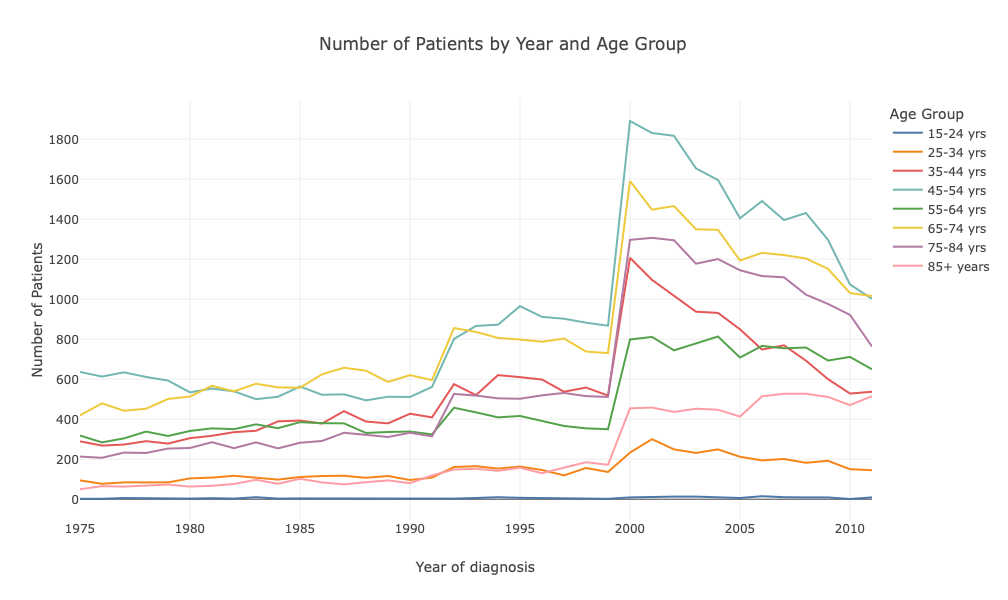

In [79]:
# year vs no of patients with age when diagnosed
fig = px.line(
        df1,
        x='Year of diagnosis',
        y='Number of Patients',
        color='Age Group', 
        title='Number of Patients by Year and Age Group',
        labels={'Number of Patients': 'Number of Patients', 'Year': 'Year'},
        color_discrete_sequence=px.colors.qualitative.T10,
        height=600
    )
fig.update_layout(yaxis=dict(tickmode='auto',  nticks=15))

fig.show()

In [94]:
df['Primary Site - labeled'].value_counts()

Primary Site - labeled
C50.4-Upper-outer quadrant of breast    46907
C50.9-Breast, NOS                       38599
C50.8-Overlapping lesion of breast      32473
C50.2-Upper-inner quadrant of breast    12526
C50.5-Lower-outer quadrant of breast     9532
C50.1-Central portion of breast          9366
C50.3-Lower-inner quadrant of breast     6978
C50.0-Nipple                             1207
C50.6-Axillary tail of breast            1177
Name: count, dtype: int64

In [96]:
with open('risk.txt', 'r') as file:
    data = file.readlines()
len(data)

280660